[rsa] running trial-by-trial RSA for source='NPRW'
[rsa][baseline] using 41 baseline trials, 128 channels
[rsa][baseline] added block 'BL' with 41 trials
[rsa][skip] 1: only 0 valid trials (< 15)
[rsa][skip] 2: only 0 valid trials (< 15)
[rsa][skip] condition 6 (in SKIP_CONDS)
[rsa][skip] 8: only 2 valid trials (< 15)
[rsa][skip] 10: only 4 valid trials (< 15)
[rsa][skip] 15: only 0 valid trials (< 15)
[rsa][skip] condition 16 (in SKIP_CONDS)
[rsa][skip] 17: only 0 valid trials (< 15)
[rsa][skip] 18: only 0 valid trials (< 15)
[rsa][skip] 27: only 0 valid trials (< 15)
[rsa] wrote /home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Nike/NRR_RW005/results/figures/rsa/RSA_NPRW_trial_by_trial_win25-175.png


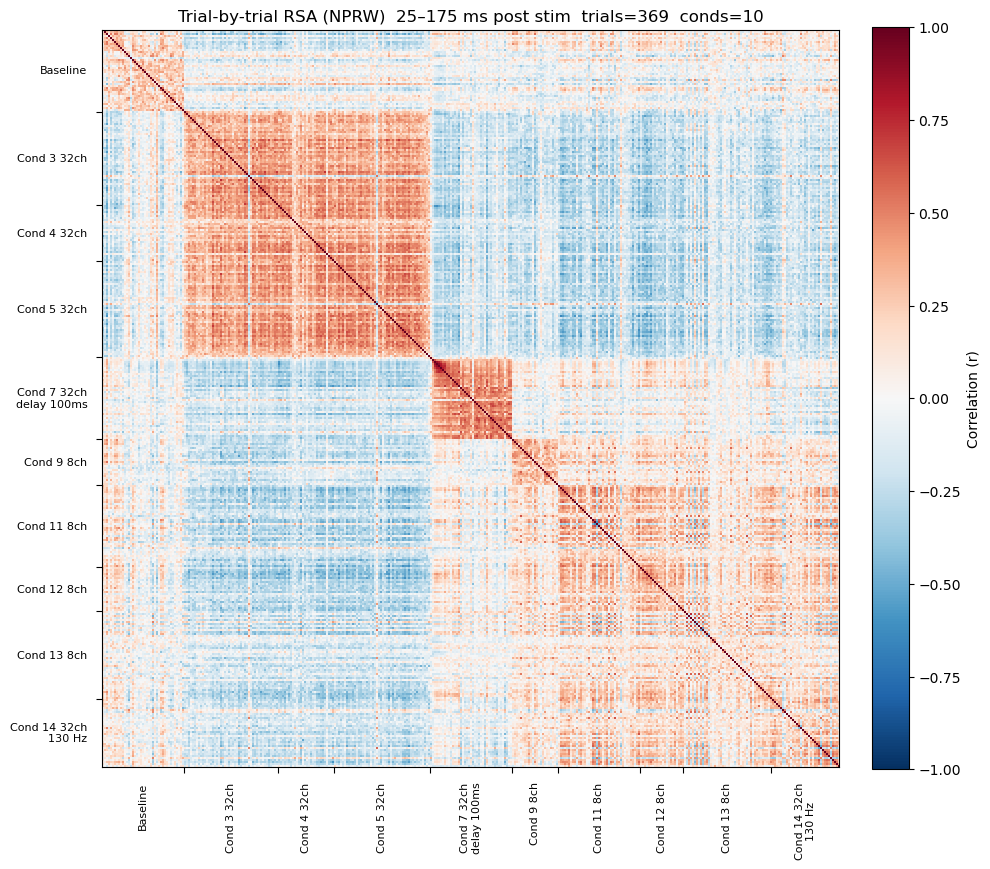

[rsa] trials=369  channels=128  conditions=10
[rsa] per-condition trial counts (after filtering): [41, 47, 28, 48, 41, 23, 41, 22, 44, 34]
[rsa] condition labels: ['Baseline', 'Cond 3 32ch', 'Cond 4 32ch', 'Cond 5 32ch', 'Cond 7 32ch\ndelay 100ms', 'Cond 9 8ch', 'Cond 11 8ch', 'Cond 12 8ch', 'Cond 13 8ch', 'Cond 14 32ch\n130 Hz']


In [ ]:
# Trial-by-trial RSA across *all* conditions (UA or NPRW)
# Paste this into the FIRST cell of a new Jupyter notebook.
# Builds an RSA matrix (trial × trial).
# Axis: small ticks BETWEEN conditions (at boundaries, no labels),
#       text labels at block centers (no ticks at the centers).
# Channel-count in labels is taken from the metadata CSV ("Channels" column),
# with fallback to the underlying rate array.

from __future__ import annotations
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import re

import RCP_analysis as rcp

# =========================
# ======= CONFIG ==========
# =========================
SOURCE = "NPRW"                # "UA" or "NPRW"
BASELINE_MS = 150.0            # baseline-zero per trial using first 150 ms in peri window
POST_WIN_MS = (25.0, 125.0)    # [stim_end + 25, stim_end + 175] ms *after stim onset+dur*
PERI_WIN_MS = (-600.0, 600.0)  # peri-stim extraction window
Z_SCORE_FEATURES = True        # z-score channels across trials before distances
SAVE_PNG = True                # save under figures/rsa/
MIN_TRIALS_PER_COND = 15       # drop conditions with fewer trials
MIN_VALID_FEATURES = 2         # trial must have at least this many finite channel features
FILE_SLICE = slice(None)       # e.g., slice(None, 10) to cap number of conditions
SKIP_CONDS = {6, 16}

# =========================
# ===== PATH RESOLVE ======
# =========================
REPO_ROOT = Path().resolve().parents[0]
PARAMS = rcp.load_experiment_params(REPO_ROOT / "config" / "params.yaml", repo_root=REPO_ROOT)
SESSION_LOC = (Path(PARAMS.data_root) / Path(PARAMS.location)).resolve()
OUT_BASE  = SESSION_LOC / "results"; OUT_BASE.mkdir(parents=True, exist_ok=True)
METADATA_ROOT = SESSION_LOC / "Metadata"; METADATA_ROOT.mkdir(parents=True, exist_ok=True)
METADATA_CSV  = METADATA_ROOT / f"{Path(PARAMS.session)}_metadata.csv"
ALIGNED_ROOT = OUT_BASE / "checkpoints" / "Aligned"
FIG_DIR = OUT_BASE / "figures" / "rsa"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---------- BASELINE (no-stim) segments for RSA ----------
CKPT_ROOT  = OUT_BASE / "checkpoints"
BEHAV_ROOT = CKPT_ROOT / "behavior" / "baseline_concat"
RATES_DIR  = BEHAV_ROOT / "rates_from_curated"

def _pick_rates_all_path(rates_dir: Path) -> tuple[Path, str]:
    """
    Prefer CURATED → ALL. Returns (path, tag).
    """
    cur = sorted(rates_dir.glob("rates_from_curated__UA_*__Depth*__CURATED.npz"))
    al  = sorted(rates_dir.glob("rates_from_curated__UA_*__Depth*__ALL.npz"))
    if cur:
        return cur[-1], "CURATED"
    if al:
        return al[-1], "ALL"
    return rates_dir / "rates_from_curated__UA_X__DepthY__ALL.npz", "ALL"

RATES_ALL_PATH, RATES_BASELINE_TAG = _pick_rates_all_path(RATES_DIR)

# =========================
# ===== METADATA HELPERS ==
# =========================
def _read_csv_robust(path: Path) -> pd.DataFrame:
    """
    Try several common encodings and tolerate a few bad rows.
    """
    encodings = ("utf-8", "utf-8-sig")
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, engine="python", on_bad_lines="skip")
        except Exception as e:
            last_err = e
            continue
    # final fallback
    from io import StringIO
    txt = Path(path).read_bytes().decode("latin-1", errors="ignore")
    return pd.read_csv(StringIO(txt), engine="python", on_bad_lines="skip")

def _load_metadata_table(csv_path: Path) -> pd.DataFrame | None:
    if not csv_path.exists():
        print(f"[meta][warn] metadata CSV not found: {csv_path}")
        return None
    df_raw = _read_csv_robust(csv_path)
    df = df_raw.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    # Drop the first row if it's a header-like row (your original iloc[1:])
    df_data = df.iloc[1:].reset_index(drop=True) if len(df) > 1 else df.copy()
    if df_data.empty:
        print("[meta][warn] metadata CSV is empty after header strip")
        return None
    return df_data

DF_META = _load_metadata_table(METADATA_CSV)

def _n_channels_from_metadata(
    br_file: int | str | None,
    sess: str | None = None,
    ua_port_preference: str = "A",
) -> int | None:
    """
    Look up 'Channels' from metadata, using similar matching logic as build_title_from_csv.
    Returns an int or None if not found.
    """
    if DF_META is None:
        return None

    df_data = DF_META
    # simple helper to get normalized column name
    def col(name: str) -> str | None:
        n = name.lower()
        return n if n in df_data.columns else None

    c_session   = col("session")
    c_brfile    = col("br_file")
    c_uaport    = col("ua_port")
    c_trigger   = col("movement_trigger")
    c_channels  = col("channels")  # this is the one we actually care about

    if c_channels is None:
        print("[meta][warn] 'Channels' column not found in metadata (after normalization)")
        return None

    mask = pd.Series(True, index=df_data.index)

    # BR_File exact match (if provided)
    if br_file is not None and c_brfile:
        try:
            br_int = int(br_file)
            m_br = (pd.to_numeric(df_data[c_brfile], errors="coerce") == br_int)
            if m_br.any():
                mask &= m_br
        except Exception:
            pass

    # session substring match
    if c_session and sess:
        m_sess = df_data[c_session].astype(str).str.contains(str(sess), regex=False, na=False)
        if (mask & m_sess).any():
            mask &= m_sess

    # prefer UA_port == 'A' (or given preference) if it doesn’t eliminate all rows
    if c_uaport and ua_port_preference:
        pref = ua_port_preference.upper().strip()
        m_port = df_data[c_uaport].astype(str).str.upper().str.strip().eq(pref)
        if (mask & m_port).any():
            mask &= m_port

    # avoid Movement_Trigger == 'velocity' when possible
    if c_trigger:
        m_not_vel = ~df_data[c_trigger].astype(str).str.strip().str.casefold().eq("velocity")
        if (mask & m_not_vel).any():
            mask &= m_not_vel

    # if we somehow killed everything, relax like in build_title_from_csv
    if not mask.any():
        mask = pd.Series(True, index=df_data.index)
        if br_file is not None and c_brfile:
            try:
                br_int = int(br_file)
                m_br = (pd.to_numeric(df_data[c_brfile], errors="coerce") == br_int)
                mask &= m_br if m_br.any() else True
            except Exception:
                pass
        if c_session and sess:
            m_sess = df_data[c_session].astype(str).str.contains(str(sess), regex=False, na=False)
            mask &= m_sess if m_sess.any() else True
        if c_uaport and ua_port_preference:
            pref = ua_port_preference.upper().strip()
            m_port = df_data[c_uaport].astype(str).str.upper().str.strip().eq(pref)
            mask &= m_port if m_port.any() else True
        if c_trigger:
            m_not_vel = ~df_data[c_trigger].astype(str).str.strip().str.casefold().eq("velocity")
            mask &= m_not_vel if m_not_vel.any() else True
        if not mask.any():
            mask = pd.Series(True, index=df_data.index)

    row = df_data.loc[mask].iloc[0]
    val = row.get(c_channels, None)
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return None

    # try numeric first
    num = pd.to_numeric(pd.Series([val]), errors="coerce").iloc[0]
    if pd.notna(num):
        return int(num)

    # otherwise, extract first integer from string
    m = re.search(r"\d+", str(val))
    if m:
        return int(m.group(0))

    return None

def _baseline_features_for_rsa(
    source: str = "UA",
    baseline_ms: float = BASELINE_MS,
    post_win_ms: tuple[float, float] = POST_WIN_MS,
) -> tuple[np.ndarray, list[str], dict]:
    """
    Use the baseline_concat rates_from_curated__UA_*__Depth*__*.npz file
    as an extra 'baseline' condition for RSA.

    Returns:
        X       : (n_baseline_trials, n_channels)
        labels  : ["BL_t1", "BL_t2", ...]
        info    : {"cond": "BL", "n_trials": int, "n_ch": int}
    """
    if not RATES_ALL_PATH.exists():
        print(f"[rsa][baseline] baseline rates file not found: {RATES_ALL_PATH}")
        return np.zeros((0, 0), float), [], {"cond": "BL", "n_trials": 0, "n_ch": 0}

    with np.load(RATES_ALL_PATH, allow_pickle=True) as z:
        if source.upper() == "UA":
            rate_win = z["ua_rate_win"].astype(float) if "ua_rate_win" in z.files else None
        else:
            # for NPRW RSA, fall back to Intan baseline if available
            rate_win = z["intan_rate_win"].astype(float) if "intan_rate_win" in z.files else None
        rel_t = z["rate_t_rel_ms"].astype(float) if "rate_t_rel_ms" in z.files else None

    if (
        rate_win is None or rel_t is None or
        rate_win.size == 0 or rel_t.size < 2
    ):
        print("[rsa][baseline] no usable baseline windows in RATES_ALL_PATH")
        return np.zeros((0, 0), float), [], {"cond": "BL", "n_trials": 0, "n_ch": 0}

    # rate_win: (N_events, n_channels, T)
    zeroed = rcp.baseline_zero_each_trial(rate_win, rel_t, normalize_first_ms=baseline_ms)

    # For baseline, treat post_win_ms as [offset from event onset, ...]
    w0 = float(post_win_ms[0])
    w1 = float(post_win_ms[1])
    mask = (rel_t >= w0) & (rel_t <= w1)
    if not np.any(mask):
        print("[rsa][baseline] post_win_ms outside rel_t range; using full window")
        mask = np.ones_like(rel_t, dtype=bool)

    # Mean over time → (N_events, n_channels)
    X = np.nanmean(zeroed[:, :, mask], axis=2)

    # Drop events that are completely NaN or too sparse
    valid = np.isfinite(X).sum(axis=1) >= MIN_VALID_FEATURES
    if not valid.any():
        print("[rsa][baseline] all baseline trials invalid after filtering")
        return (
            np.zeros((0, 0), float),
            [],
            {"cond": "BL", "n_trials": 0, "n_ch": X.shape[1] if X.ndim == 2 else 0},
        )
    X = X[valid, :]

    labels = [f"BL_t{j+1}" for j in range(X.shape[0])]
    info = {
        "cond": "BL",
        "n_trials": X.shape[0],   # <- use shape[0], not shape_
        "n_ch": X.shape[1],       # <- add n_ch for labeling
    }
    print(f"[rsa][baseline] using {X.shape[0]} baseline trials, {X.shape[1]} channels")
    return X, labels, info

 
# =========================
# ====== RSA FUNCTIONS ====
# =========================
def _trial_features_for_file(
    npz_path: Path,
    source: str = "UA",
    baseline_ms: float = BASELINE_MS,
    peri_win_ms: tuple[float, float] = PERI_WIN_MS,
    post_win_ms: tuple[float, float] = POST_WIN_MS,
) -> tuple[np.ndarray, list[str], dict]:
    """
    Build one feature vector per trial by averaging channel rates over a post-stim window.

    Returns:
        X : (n_trials, n_channels)
        labels : ["cond{br_idx}_t{j}", ...]
        info : {"cond": br_idx, "n_trials": int, "n_ch": int}
    """
    NPRW_rate, NPRW_t, UA_rate, UA_t, stim_ms_abs, meta = rcp.load_combined_npz(npz_path)
    stim_ms = rcp.aligned_stim_ms(stim_ms_abs, meta)

    cond = meta.get("br_idx", Path(npz_path).stem)
    sess = meta.get("session", None)

    # First try to get channels from metadata CSV
    n_ch_meta = _n_channels_from_metadata(br_file=cond, sess=sess)

    if source.upper() == "UA":
        rate = UA_rate
        tvec = UA_t
    else:
        rate = NPRW_rate
        tvec = NPRW_t

    # Also check underlying rate array shape if available
    n_ch_rate = None
    if rate is not None and hasattr(rate, "shape") and len(rate.shape) >= 1:
        try:
            n_ch_rate = int(rate.shape[0])
        except Exception:
            n_ch_rate = None

    # Final source of truth for n_ch
    n_ch_source = (
        n_ch_meta if (n_ch_meta is not None)
        else n_ch_rate if (n_ch_rate is not None)
        else int(meta.get("n_ch", 0))
    )

    if rate is None or rate.size == 0 or tvec is None or tvec.size < 2 or stim_ms.size == 0:
        return np.zeros((0, 0), float), [], {
            "cond": cond,
            "n_trials": 0,
            "n_ch": n_ch_source,
        }

    # Extract ALL peri-stim segments (no median) → (N_trials, n_channels, T)
    try:
        segs, rel_t = rcp.extract_peristim_segments(
            rate_hz=rate, t_ms=tvec, stim_ms=stim_ms, win_ms=peri_win_ms, min_trials=1
        )
    except RuntimeError:
        return np.zeros((0, 0), float), [], {
            "cond": cond,
            "n_trials": 0,
            "n_ch": n_ch_source,
        }
    if segs.size == 0:
        return np.zeros((0, 0), float), [], {
            "cond": cond,
            "n_trials": 0,
            "n_ch": n_ch_source,
        }

    # Baseline-zero each trial (per channel)
    segs = rcp.baseline_zero_each_trial(segs, rel_t, normalize_first_ms=baseline_ms)  # (N, C, T)

    # Post-stim window: [stim_end + POST_WIN_MS[0], stim_end + POST_WIN_MS[1]] ms
    stim_dur = 100
    w0 = stim_dur + float(post_win_ms[0])
    w1 = stim_dur + float(post_win_ms[1])
    mask = (rel_t >= w0) & (rel_t <= w1)
    if not np.any(mask):
        # Fallback absolute window
        mask = (rel_t >= 125.0) & (rel_t <= 275.0)
        if not np.any(mask):
            return np.zeros((0, 0), float), [], {
                "cond": cond,
                "n_trials": 0,
                "n_ch": n_ch_source,
            }

    # Mean over time within the window → (N, C)
    X = np.nanmean(segs[:, :, mask], axis=2)

    labels = [f"cond{cond}_t{j+1}" for j in range(X.shape[0])]
    return X, labels, {
        "cond": cond,
        "n_trials": X.shape[0],
        "n_ch": n_ch_source,
    }

def _plot_rdm_with_block_ticks(
    SIM: np.ndarray,
    block_sizes: list[int],
    block_labels: list[str],
    title: str,
    out_png: Path | None,
):
    """
    Plot *similarity* matrix (correlation r in [-1, 1]) with:
      - small ticks BETWEEN conditions at block boundaries (no labels)
      - text labels centered on each block (no ticks at centers),
        mirrored on all four sides: bottom/top and left/right.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(
        SIM,
        aspect="equal",
        origin="upper",
        interpolation="nearest",
        cmap="RdBu_r",
        vmin=-1.0,
        vmax=1.0,
    )
    ax.set_title(title)

    # Compute block starts, boundaries, and centers
    cum = np.cumsum(block_sizes)
    starts = np.r_[0, cum[:-1]]
    boundaries = cum[:-1] - 0.5        # between-condition boundaries in pixel coords
    centers = starts + (np.asarray(block_sizes) / 2.0) - 0.5

    # 1) Boundary ticks (minor): between conditions, no labels
    ax.set_xticks(boundaries, minor=True)
    ax.set_yticks(boundaries, minor=True)
    ax.tick_params(axis="x", which="minor", length=4, width=0.8, direction="out")
    ax.tick_params(axis="y", which="minor", length=4, width=0.8, direction="out")

    # 2) No major ticks (we’ll draw text instead)
    ax.set_xticks([])
    ax.set_yticks([])

    # 3) Text labels at centers (no ticks), on all four sides
    for c, lab in zip(centers, block_labels):
        # Bottom labels (x-axis)
        ax.text(
            c, -0.02, lab,
            transform=ax.get_xaxis_transform(),  # axis coords in y
            ha="center", va="top",
            fontsize=8, rotation=90,
            clip_on=False,
        )
        # Left labels (y-axis)
        ax.text(
            -0.02, c, lab,
            transform=ax.get_yaxis_transform(),  # axis coords in x
            ha="right", va="center",
            fontsize=8,
            clip_on=False,
        )

    cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Correlation (r)")
    fig.tight_layout()
    if out_png is not None:
        fig.savefig(out_png, dpi=300)
        print(f"[rsa] wrote {out_png}")
    plt.show()
    plt.close(fig)
# =========================
# ======= RUN RSA =========
# =========================
def run_trial_rsa(
    source: str = SOURCE,
    post_win_ms: tuple[float, float] = POST_WIN_MS,
    ):
    """
    Run trial-by-trial RSA for the requested source ("UA" or "NPRW").
    Uses all the global config + helpers defined above.
    """
    print(f"[rsa] running trial-by-trial RSA for source={source!r}")

    files = sorted(ALIGNED_ROOT.glob("aligned__*.npz"))[FILE_SLICE]
    if not files:
        raise SystemExit(f"[rsa] no aligned files found at {ALIGNED_ROOT}")

    all_X, all_labels = [], []
    block_sizes, cond_order, cond_chans = [], [], []

    # ----- 3a) prepend BASELINE as first block -----
    X_bl, labels_bl, info_bl = _baseline_features_for_rsa(
        source=source,
        baseline_ms=BASELINE_MS,
        post_win_ms=post_win_ms,
    )
    if X_bl.size and info_bl.get("n_trials", 0) >= MIN_TRIALS_PER_COND:
        all_X.append(X_bl)
        all_labels.extend(labels_bl)
        block_sizes.append(X_bl.shape[0])
        cond_order.append(info_bl.get("cond", "BL"))
        cond_chans.append(info_bl.get("n_ch", X_bl.shape[1]))
        print(f"[rsa][baseline] added block 'BL' with {X_bl.shape[0]} trials")
    else:
        print("[rsa][baseline] not enough baseline trials, skipping baseline block")

    # ----- 3b) then loop over stim conditions as before -----
    for f in files:
        try:
            X, labels, info = _trial_features_for_file(
                f,
                source=source,
                baseline_ms=BASELINE_MS,
                peri_win_ms=PERI_WIN_MS,
                post_win_ms=post_win_ms,
            )
        except Exception as e:
            print(f"[rsa][warn] failed on {f.name}: {e}")
            continue

        cond_val = info.get("cond", None)
        try:
            cond_int = int(cond_val)
        except (TypeError, ValueError):
            cond_int = None

        if cond_int in SKIP_CONDS:
            print(f"[rsa][skip] condition {cond_int} (in SKIP_CONDS)")
            continue

        # channel count from metadata CSV / rate (not from X after filtering)
        n_ch_meta = int(info.get("n_ch", 0))

        # Drop invalid trials (e.g., all-NaN features) *before* counting trials
        if X.size:
            trial_valid = np.isfinite(X).sum(axis=1) >= MIN_VALID_FEATURES
            if not trial_valid.all():
                n_drop = int((~trial_valid).sum())
                print(f"[rsa][note] dropping {n_drop} invalid trials in {f.stem}")
            X = X[trial_valid, :]
            labels = [lbl for lbl, keep in zip(labels, trial_valid) if keep]

            # Drop channels that are all-NaN across remaining trials (pre-zscore)
            ch_valid = np.isfinite(X).any(axis=0)
            if not ch_valid.all():
                n_ch_drop = int((~ch_valid).sum())
                print(f"[rsa][note] dropping {n_ch_drop} all-NaN channels in {f.stem}")
            X = X[:, ch_valid]

        n_trials = int(X.shape[0]) if X is not None else 0
        if n_trials < MIN_TRIALS_PER_COND:
            cond_name = info.get("cond", f.stem) if isinstance(info, dict) else f.stem
            print(f"[rsa][skip] {cond_name}: only {n_trials} valid trials (< {MIN_TRIALS_PER_COND})")
            continue

        all_X.append(X)
        all_labels.extend(labels)
        block_sizes.append(n_trials)
        cond_order.append(info.get("cond"))
        cond_chans.append(n_ch_meta)

    if not all_X:
        raise SystemExit("[rsa] no trials found across selected conditions")

    X_all = np.vstack(all_X)  # (N_total_trials, n_channels_combined)

    # Optional channel-wise z-score across trials (after concatenation)
    if Z_SCORE_FEATURES and X_all.size:
        with np.errstate(invalid="ignore", divide="ignore"):
            mu = np.nanmean(X_all, axis=0, keepdims=True)
            sd = np.nanstd(X_all, axis=0, keepdims=True)
            X_all = (X_all - mu) / np.where(sd > 0, sd, 1.0)

    # Final safety: remove any trial rows that still contain NaNs
    row_valid = np.isfinite(X_all).all(axis=1)
    if not row_valid.all():
        print(f"[rsa][note] dropping {int((~row_valid).sum())} trials post-normalization")
        # Recompute per-condition sizes
        new_block_sizes = []
        cursor = 0
        for sz in block_sizes:
            block_idx = np.arange(cursor, cursor + sz)
            kept_in_block = np.intersect1d(block_idx, np.where(row_valid)[0], assume_unique=False)
            new_block_sizes.append(int(kept_in_block.size))
            cursor += sz
        # Filter out empty conditions, keeping cond_order/cond_chans aligned
        triples = [(s, c, ch) for s, c, ch in zip(new_block_sizes, cond_order, cond_chans) if s > 0]
        if not triples:
            raise SystemExit("[rsa] all conditions empty after post-normalization filtering")
        block_sizes, cond_order, cond_chans = map(list, zip(*triples))
        X_all = X_all[row_valid, :]
        all_labels = [lbl for lbl, keep in zip(all_labels, row_valid) if keep]

    # If after filtering any condition is empty, drop it from ticks
    block_sizes = [s for s in block_sizes if s > 0]
    if not block_sizes:
        raise SystemExit("[rsa] all conditions empty after filtering")

    # Correlation *similarity* matrix across trials (r in [-1, 1])
    SIM = np.corrcoef(X_all)

    # Tick labels at condition centers, e.g., "Cond 3 32ch\nextra"
    block_labels = []
    for cond, nch in zip(cond_order, cond_chans):
        if cond == "BL":
            label = "Baseline"
        else:
            # "Cond" + space, no underscore
            base = f"Cond {cond} {nch}ch"
            extra = ""
            try:
                cond_int = int(cond)
            except (TypeError, ValueError):
                cond_int = None

            if cond_int == 7:
                extra = "\ndelay 100ms"
            elif cond_int == 14:
                extra = "\n130 Hz"

            label = base + extra

        block_labels.append(label)



    # Title includes counts
    title = (
        f"Trial-by-trial RSA ({source})  "
        f"{int(post_win_ms[0])}–{int(post_win_ms[1])} ms post stim  "
        f"trials={X_all.shape[0]}  conds={len(block_sizes)}"
    )

    out_png = (
        FIG_DIR / f"RSA_{source}_trial_by_trial_win{int(post_win_ms[0])}-{int(post_win_ms[1])}.png"
        if SAVE_PNG else None
    )

    _plot_rdm_with_block_ticks(SIM, block_sizes, block_labels, title, out_png)

    print(f"[rsa] trials={X_all.shape[0]}  channels={X_all.shape[1]}  conditions={len(block_sizes)}")
    print(f"[rsa] per-condition trial counts (after filtering): {block_sizes}")
    print(f"[rsa] condition labels: {block_labels}")


# --- example usage in THIS cell ---
# First run NPRW (as you have in CONFIG)
run_trial_rsa("NPRW", post_win_ms=(25.0, 175.0))

[rsa] running trial-by-trial RSA for source='UA'


[rsa][baseline] using 40 baseline trials, 128 channels
[rsa][baseline] added block 'BL' with 40 trials


/tmp/ipykernel_25497/2635810898.py:243: RuntimeWarning: Mean of empty slice
  X = np.nanmean(zeroed[:, :, mask], axis=2)


[rsa][skip] 1: only 0 valid trials (< 15)
[rsa][skip] 2: only 0 valid trials (< 15)
[rsa][skip] condition 6 (in SKIP_CONDS)
[rsa][skip] 8: only 2 valid trials (< 15)
[rsa][skip] 10: only 4 valid trials (< 15)


/home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Bryan/RCP_analysis/RCP_analysis/python/functions/utils.py:578: RuntimeWarning: Mean of empty slice
  base = np.nanmean(segments[:, :, mask], axis=2, keepdims=True)  # (n_trials, n_ch, 1)
/tmp/ipykernel_25497/2635810898.py:359: RuntimeWarning: Mean of empty slice
  X = np.nanmean(segs[:, :, mask], axis=2)


[rsa][note] dropping 1 invalid trials in aligned__NRR_RW005_251017_151326__Intan_012__BR_012


/home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Bryan/RCP_analysis/RCP_analysis/python/functions/utils.py:578: RuntimeWarning: Mean of empty slice
  base = np.nanmean(segments[:, :, mask], axis=2, keepdims=True)  # (n_trials, n_ch, 1)
/tmp/ipykernel_25497/2635810898.py:359: RuntimeWarning: Mean of empty slice
  X = np.nanmean(segs[:, :, mask], axis=2)


[rsa][note] dropping 1 invalid trials in aligned__NRR_RW005_251017_151632__Intan_013__BR_013
[rsa][skip] 15: only 0 valid trials (< 15)
[rsa][skip] condition 16 (in SKIP_CONDS)
[rsa][skip] 17: only 0 valid trials (< 15)
[rsa][skip] 18: only 0 valid trials (< 15)
[rsa][skip] 27: only 0 valid trials (< 15)
[rsa] wrote /home/bryan/mnt/cullen/Current Project Databases - NHP/2025 Cerebellum prosthesis/Nike/NRR_RW005/results/figures/rsa/RSA_UA_trial_by_trial_win25-275.png


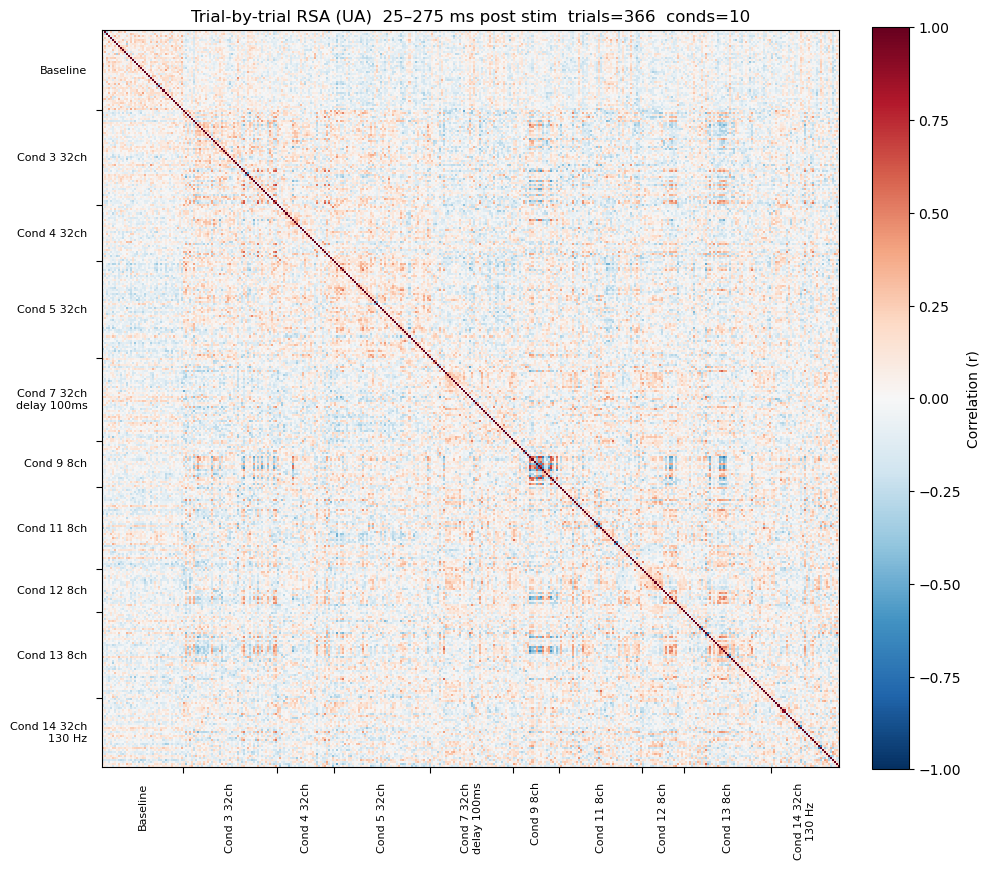

[rsa] trials=366  channels=128  conditions=10
[rsa] per-condition trial counts (after filtering): [40, 47, 28, 48, 41, 23, 41, 21, 43, 34]
[rsa] condition labels: ['Baseline', 'Cond 3 32ch', 'Cond 4 32ch', 'Cond 5 32ch', 'Cond 7 32ch\ndelay 100ms', 'Cond 9 8ch', 'Cond 11 8ch', 'Cond 12 8ch', 'Cond 13 8ch', 'Cond 14 32ch\n130 Hz']


In [57]:
run_trial_rsa("UA", post_win_ms=(25.0, 275.0))